In [1]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'

# load Terra API for get data table from Terra
import sys
import glob
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *

# load packages and data for the following analysis
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
obs_path = f'{RESULT_TABLE}/annotation/Myeloid.csv'
adata = sc.read(f'{RESULT_OBJ}/gex_all.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
adata = adata[adata.obs.index.isin(obs.index[obs.Celltype=='Macs']),:]
print(f'{adata.obs.shape[0]:,} Macrophages')
sample_meta =  pd.read_excel(f'{RESULT_TABLE}/Supplementary Table 1.xlsx',index_col=0).replace(np.nan,'N/A')
Celltype='Macs'

13,375 Macrophages


# Detect the robust recurrent program robustRPH

- Run the workflow https://app.terra.bio/#workspaces/vanallen-firecloud-nih/HR_BrCa_16-466/workflows/jf_scpipe_rna/GEX_CohortSet_DetectRHP
- Get the basis and coef pickle files.

In [3]:
import pickle
with open(f'{RESULT_TABLE}/MPs/{Celltype}/nmf_basis.pickle', "rb") as input_file:
    programs_basis = pickle.load(input_file)

with open(f'{RESULT_TABLE}/MPs/{Celltype}/nmf_coef.pickle', "rb") as input_file:
    programs_coef = pickle.load(input_file)
    
n_programs = programs_basis[list(programs_basis.keys())[2]].shape[1] * len(programs_basis)
f"Generated {n_programs:,} programs"

'Generated 702 programs'

In [4]:
n_top=50
# if not os.path.isdir(f'{RESULT_TABLE}/MPs/{Celltype}'):
#     os.makedirs(f'{RESULT_TABLE}/MPs/{Celltype}')
# robustRPH = sp.ext.getRobustRHP(programs=programs_basis,
#                          n_top=n_top,
#                          intra_min = 35, inter_min = 10,intra_max = 10
#                         )
# with open(f'{RESULT_TABLE}/MPs/{Celltype}/robustRPH.pickle', 'wb') as handle:
#     pickle.dump(robustRPH, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{RESULT_TABLE}/MPs/{Celltype}/robustRPH.pickle', "rb") as input_file:
    robustRPH = pickle.load(input_file)
f"Out of {n_programs:,} detected programs, {robustRPH.shape[1]} programs are robust."

'Out of 702 detected programs, 111 programs are robust.'

## Get a list of genes included in the analysis

In [5]:
bg_genes = pd.Index([])
for k,v in programs_basis.items():
    bg_genes = v.index.union(bg_genes)

## Customized clustering on the RPH

### Look at how the n of samples in various timepoints and conditions


In [6]:
sample_stats = pd.crosstab(index=[sample_meta['Treatment_Arm'],sample_meta['Timepoint']],
            columns=sample_meta['BestResponse'])

sample_stats['total'] =sample_stats.sum(axis=1)
sample_stats

BestResponse               favorable response\n(RCB 0-I)  \
Treatment_Arm Timepoint                                    
Chemo->Combo  Baseline                                 1   
              Pre-surgery                              0   
              Surgery                                  1   
              W3D1                                     2   
              W7D1                                     3   
ICI->Combo    Baseline                                 2   
              Pre-surgery                              1   
              Surgery                                  0   
              W3D1                                     0   
              W7D1                                     1   

BestResponse               unfavorable response\n(RCB II-III)  total  
Treatment_Arm Timepoint                                               
Chemo->Combo  Baseline                                      3      4  
              Pre-surgery                                   2      2  
              Surgery                                       2      3  
              W3D1                                          3      5  
              W7D1                                          1      4  
ICI->Combo    Baseline                                      6      8  
              Pre-surgery                                   1      2  
              Surgery                                       4      4  
              W3D1                                          4      4  
              W7D1                                          3      4

### Perform the clustering

as shown above, in timepoints Baseline, W3D1, W7D1, and AfterSurg, we have at least `2` samples per timepoints. Thus, we aimed to find metaprograms that at least shared among three samples and set the `Min_group_size` parameter to be `2`.

In [7]:
import palettable
Cluster_Map,MP_Genesets,Programs_Order,MP_colors = sp.ext.clusterRobustRPH(
    robustRPH=robustRPH,
    programs_basis=programs_basis,
    Min_group_size=2,
    palette=palettable.tableau.Tableau_20.hex_colors + palettable.tableau.TrafficLight_9.hex_colors
)

[Processing]Cluster MP1 has 19 RPH programs.
[Processing]Cluster MP2 has 6 RPH programs.
[Processing]Cluster MP3 has 12 RPH programs.
[Processing]Cluster MP4 has 13 RPH programs.
[Processing]Cluster MP5 has 12 RPH programs.
[Processing]Cluster MP6 has 11 RPH programs.
[Processing]Cluster MP7 has 7 RPH programs.
[Processing]Cluster MP8 has 5 RPH programs.
[Processing]Cluster MP9 has 4 RPH programs.
[Done] Generated 9 MP clusters which covered 80% robust RPH programs.


### Look at MPs related to low data quality 

In [8]:
display(pd.concat([
    MP_Genesets.apply(lambda c:c.str.startswith('MT-').sum(),axis=0).rename('Mitochondrial'),
    MP_Genesets.apply(lambda c:c.str.contains('^RP[LS]').sum(),axis=0).rename('Ribosomal')
],axis=1).sort_values(['Mitochondrial','Ribosomal'],ascending=False))

low_quality_mps = ['MP3']

,Mitochondrial,Ribosomal
MP3,9,27
MP2,0,2
MP4,0,1
MP1,0,0
MP5,0,0
MP6,0,0
MP7,0,0
MP8,0,0
MP9,0,0


### Merge sample metadata into the clustering result

In [9]:
anno = Cluster_Map.rename('MetaProgram').to_frame()
anno['Sample'] = anno.index.map(lambda x: x.split('.')[0])
anno = anno.reset_index().merge(sample_meta,left_on='Sample',right_on='CCG_ID',how='left').set_index('index')

### explore the patient specific programs

In [10]:
pt_specific = anno.groupby(['MetaProgram'])['Patient'].nunique().sort_values()
pt_specific = pt_specific[pt_specific ==1].index.tolist()

In [11]:
anno['MetaProgram'].value_counts()[pt_specific]

Series([], Name: MetaProgram, dtype: int64)

In [12]:
anno.loc[anno['MetaProgram'].isin(pt_specific),:]

,MetaProgram,Sample,CCG_ID,BluePrint,AC_Treatment,Tech,WES_Profile,BulkRNA_Profile,PAM50,BestResponse,Timepoint,stage,Patient,Treatment_Arm
index,,,,,,,,,,,,,,


###  Calculate the complexity correaltion

In [13]:
nmf_corr_complexity = []
for k,v in programs_coef.items():
    # only keep cells iwth genes > 1,000
    tmp = v.corrwith(adata.obs.loc[adata.obs.index.isin(v.index),'n_genes_by_counts'])
    nmf_corr_complexity.append(tmp)
del tmp
nmf_corr_complexity=pd.concat(nmf_corr_complexity,axis=0)
dt = pd.concat([nmf_corr_complexity.abs()>.4,Cluster_Map],axis=1,join='inner').groupby(1)[0].mean()
high_complexity = dt[dt>.5].index.tolist()
high_complexity

['MP2', 'MP9']

### Remove patient specific, high complexity, and unknown program

In [14]:
anno = anno.loc[~anno['MetaProgram'].isin(pt_specific+['MP_Unknown']+low_quality_mps+high_complexity),:]
New_Programs_Order = [ x for x in Programs_Order if x in anno.index]
New_MP_Genesets = MP_Genesets[anno['MetaProgram'].unique().tolist()]
f"Generated {anno['MetaProgram'].nunique()} MP clusters which covered {(anno.shape[0]/robustRPH.shape[1]):.0%} robust RPH programs."

'Generated 6 MP clusters which covered 60% robust RPH programs.'

## Visualize the program similarity 

### Visualize the similarity

In [15]:
def jaccard_index(c1,c2):
    c1 = set(c1)
    c2 = set(c2)
    overlap =  c1.intersection(c2)
    union = c1.union(c2)
    value = len(overlap)/len(union)
    return value

## Jaccard index    
sm = robustRPH.apply(
        lambda c1:
            robustRPH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.22361111111111 mm


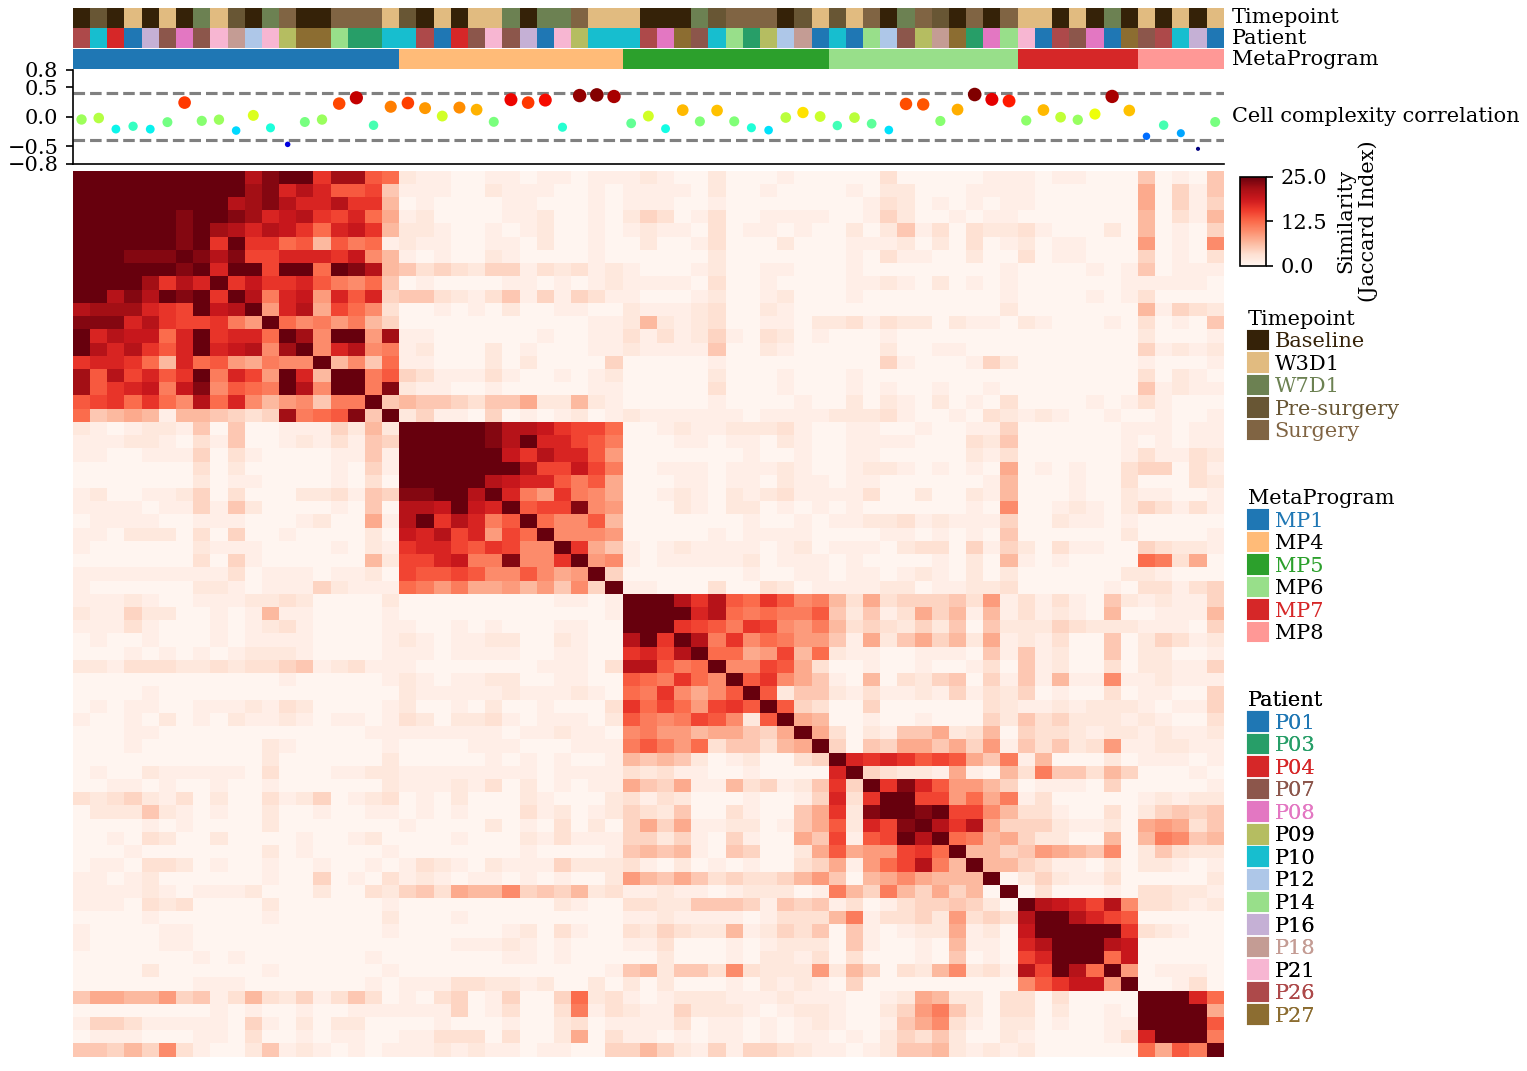

In [16]:
from PyComplexHeatmap import \
ClusterMapPlotter,HeatmapAnnotation,anno_simple,anno_label,DotClustermapPlotter,anno_scatterplot
## Get the order the program
anno['Cell_complexity_cor'] = nmf_corr_complexity
order = New_Programs_Order

## column annotation
n_mp = Cluster_Map.nunique()
COLOR_PAlETTE['MetaProgram'] = MP_colors
col_dict={}
for col in ['Timepoint','Patient','MetaProgram']:#'Treatment_Arm',
    colors = { k:v for k,v in COLOR_PAlETTE[col].items() if k in anno[col].unique()}
    col_dict[col] = anno_simple(anno[col],
                              legend_kws=dict(frameon=False),
                              colors=colors)
    
col_dict['Cell complexity correlation']= anno_scatterplot(
    anno['Cell_complexity_cor'],height=14,legend=False,grid=False
)

col_ha = HeatmapAnnotation(**col_dict,verbose=0,axis=1)
row_ha = HeatmapAnnotation(
    MetaProgram = anno_simple(anno['MetaProgram'],legend=False),verbose=0,axis=0
)
## plot
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 8),dpi=150)


cm = ClusterMapPlotter(data=sm.loc[order,order],
                       top_annotation=col_ha,
                       row_cluster=False,col_cluster=False,
#                        left_annotation=row_ha,
#                        col_split=rph_anno['RPH'],row_split=rph_anno['RPH'],
#                        row_split_gap=0.8,col_split_gap=0.8,
                       vmin=0,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='Reds',rasterized=True)

## Change the ylim for the correlation plot
cutoff=.4
ax=col_ha.annotations[3].ax
ax.set_yticks([-0.8,-0.5,0,0.5,0.8]);
ax.axhline(y=cutoff,ls='--',color='gray')
ax.axhline(y=-cutoff,ls='--',color='gray')

## Write out the Genesets for every MP

In [17]:
mp_gmt_path = f'{RESULT_TABLE}/MPs/{Celltype}/MP_Programs.gmt'
with open(mp_gmt_path,'w') as f:
    for mp in New_MP_Genesets:
        f.write('\t'.join([mp,'MetaProgram_HRpos']+MP_Genesets[mp].tolist())+'\n')

# Annotation of reccurent program

## Gavish et al. 2023 - Hallmarks of transcriptional intratumour heterogeneity across a thousand tumours

In [18]:
ref_ITH = pd.read_excel(f'{EXTERNAL_DATA}/meta_programs_2023-07-13.xlsx',sheet_name='Macrophages')
ref_ITH = ref_ITH.loc[:,ref_ITH.columns!='Unassigned']

### Similarity of individual RHP with reference ITH

In [19]:
n_top = min(ref_ITH.shape[0],robustRPH.shape[0])
rph_ref_sm = robustRPH.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.22361111111111 mm


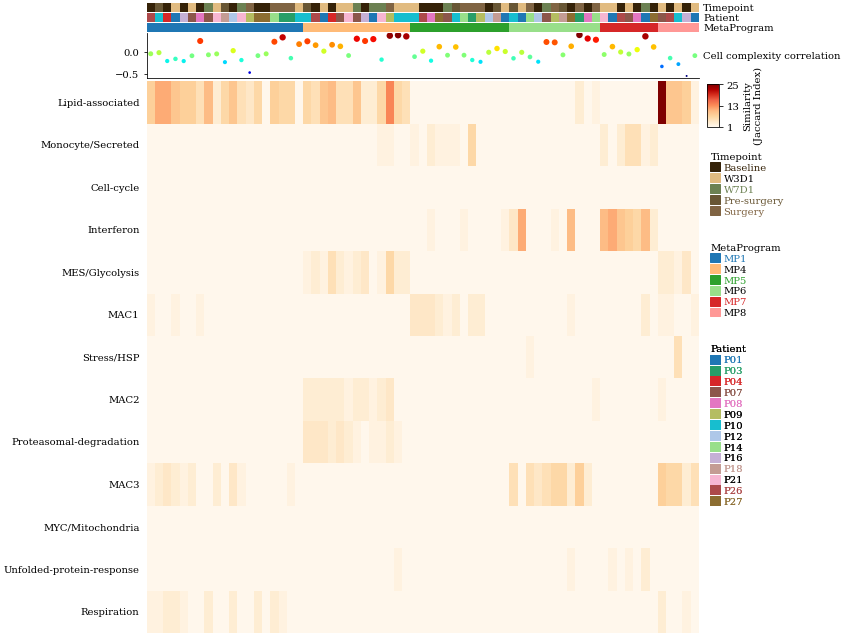

In [20]:
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 10))
cm = ClusterMapPlotter(data=rph_ref_sm.loc[:,order],
                       top_annotation=col_ha,
                       left_annotation=None,
                       show_rownames=True,
                       row_names_side='left',
                       row_cluster=False,col_cluster=False,
                       vmin=1,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='OrRd',rasterized=True)

### Similarity of metaRHP with reference ITH

In [21]:
(New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0).max().sort_values() > 5)

MP5    False
MP1     True
MP4     True
MP6     True
MP7     True
MP8     True
dtype: bool

<Axes: >

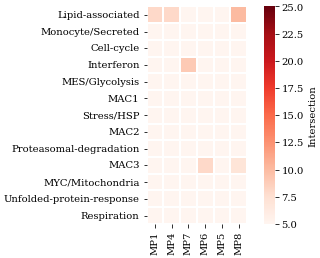

In [22]:
meta_ref_sm = New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0)
meta_ref_sm = meta_ref_sm#.loc[((meta_ref_sm >= 10).sum(axis=1)>=1),((meta_ref_sm >= 10).sum(axis=0)>=1)]
sns.heatmap(meta_ref_sm,lw=.2,
              cmap='Reds',vmin=5,vmax=25,square=True,cbar_kws={'label':'Intersection'})

## Hallmark and GO term bp/cc Geneset Enricher 

In [23]:
import gseapy as gp
MP_pathway = {}
for program in New_MP_Genesets:
    genelist = New_MP_Genesets[program].tolist()
    get = True
    while get:
        try:
            enr = gp.enrichr(gene_list=genelist,
                     gene_sets=[f"{EXTERNAL_DATA}/KEGG_2021_Human.gmt",
                                f"{EXTERNAL_DATA}/h.all.v2023.1.Hs.symbols.gmt",
                                f"{EXTERNAL_DATA}/c5.go.bp.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.cc.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.mf.v2023.1.Hs.symbols.gmt"],
                     organism='human',
                     background=bg_genes.tolist(),
                     outdir=None, # don't write to disk
                            )
            get = False
        except Exception as e:
            if e!='Error sending gene list, try again later':
                print(e)
    res = enr.results
#     res = res.loc[res['Adjusted P-value']<0.05,:]
    MP_pathway[program] = res


top_n = 10
enr_res = {}
with pd.ExcelWriter(f'{RESULT_TABLE}/MPs/{Celltype}/ITH_Enricher.xlsx') as file:
    for name,temp in MP_pathway.items():
        top_geneset = []
        for geneset,df in temp.groupby('Gene_set'):
            top_geneset.append(
                df.sort_values(['Adjusted P-value'],
                                ascending=True).head(top_n)
            )
        result = pd.concat(top_geneset,axis=0)
        result.to_excel(file, sheet_name = name, index=False)
        enr_res[name] = result
del temp,result

In [24]:
enr_res = pd.read_excel(f'{RESULT_TABLE}/MPs/{Celltype}/ITH_Enricher.xlsx', sheet_name=None)

## Manual annotation

we recorded evidences for the program annotaion in the suppl slides.

In [25]:
enr_res['MP1']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human.gmt,Melanoma,2/41,1.408631e-02,0.279249,14.635913,62.386341,PDGFC;IGF1
1,KEGG_2021_Human.gmt,Hypertrophic cardiomyopathy,2/45,1.681713e-02,0.279249,13.285342,54.275370,TTN;IGF1
2,KEGG_2021_Human.gmt,Complement and coagulation cascades,2/40,1.343679e-02,0.279249,15.017405,64.721396,CR1;F13A1
3,KEGG_2021_Human.gmt,Dilated cardiomyopathy,2/47,1.826044e-02,0.279249,12.699105,50.834751,TTN;IGF1
4,KEGG_2021_Human.gmt,Ras signaling pathway,3/130,1.966544e-02,0.279249,6.430753,25.265739,PDGFC;IGF1;RGL1
5,KEGG_2021_Human.gmt,Inflammatory mediator regulation of TRP channels,2/56,2.536791e-02,0.300187,10.593493,38.923357,IGF1;HRH1
6,KEGG_2021_Human.gmt,N-Glycan biosynthesis,1/35,1.439189e-01,0.349598,9.855512,19.104961,MAN1A1
7,KEGG_2021_Human.gmt,Long-term depression,1/34,1.401039e-01,0.349598,10.150611,19.949713,IGF1
8,KEGG_2021_Human.gmt,Ovarian steroidogenesis,1/19,8.083970e-02,0.349598,18.405405,46.294878,IGF1
9,KEGG_2021_Human.gmt,Phagosome,2/114,9.038062e-02,0.349598,5.105384,12.271940,COLEC12;MRC1


In [26]:
New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0).idxmax().to_dict()

{'MP1': 'Lipid-associated',
 'MP4': 'Lipid-associated',
 'MP7': 'Interferon',
 'MP6': 'MAC3',
 'MP5': 'MAC1',
 'MP8': 'Lipid-associated'}

## Final MP annotation

In [27]:
MP_anno_map = {

    'MP1': 'Endocytosis',
    'MP4': 'Lipid',
    'MP7': 'Interferon',
    'MP6': 'Adhesion',
    'MP5': 'Secretion',
    'MP8': 'Presentation'
    
    # 'MP2': 'Lipid-IGF1',
    # 'MP3': 'Lipid-APOE',
    # 'MP7': 'Interferon',
    # 'MP6': 'Cholinergic', # https://www.nature.com/articles/cddiscovery201663
    # 'MP5': 'Adipogenesis',
    # 'MP4': 'MHCII'
}

## Assign the annotation to MPs column

In [28]:
anno['MPs'] = anno.MetaProgram.map(MP_anno_map)
anno['MPs'].value_counts().sort_index()

Adhesion        11
Endocytosis     19
Interferon       7
Lipid           13
Presentation     5
Secretion       12
Name: MPs, dtype: int64

In [29]:
MP_Visual_Genes = {
    'MP1':  ['MRC1','STAB1','DAB2'],
    'MP4': ['LGALS3','LIPA','PLPP3'],
    'MP7': ['CXCL9','STAT1','CXCL10'],
    'MP6': ['ALCAM','CADM1','DOCK4'],
    'MP5': ['PLCB1','ITPR1','CREB5'],
    'MP8': ['C1QC','HLA-DQA1','HLA-A']
    
    # 'MP2':
    # 'MP3': ['APOE','PDE3B','MGLL'],
    # 'MP7': ['CXCL9','STAT1','CXCL10'],
    # 'MP6': ['CREB5','PRKCB','ITPR1'],
    # 'MP5': ['SPP1','LPL','FABP4'],
    # 'MP4': ['IFI44L','HLA-DQA1','CX3CR1']
}

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


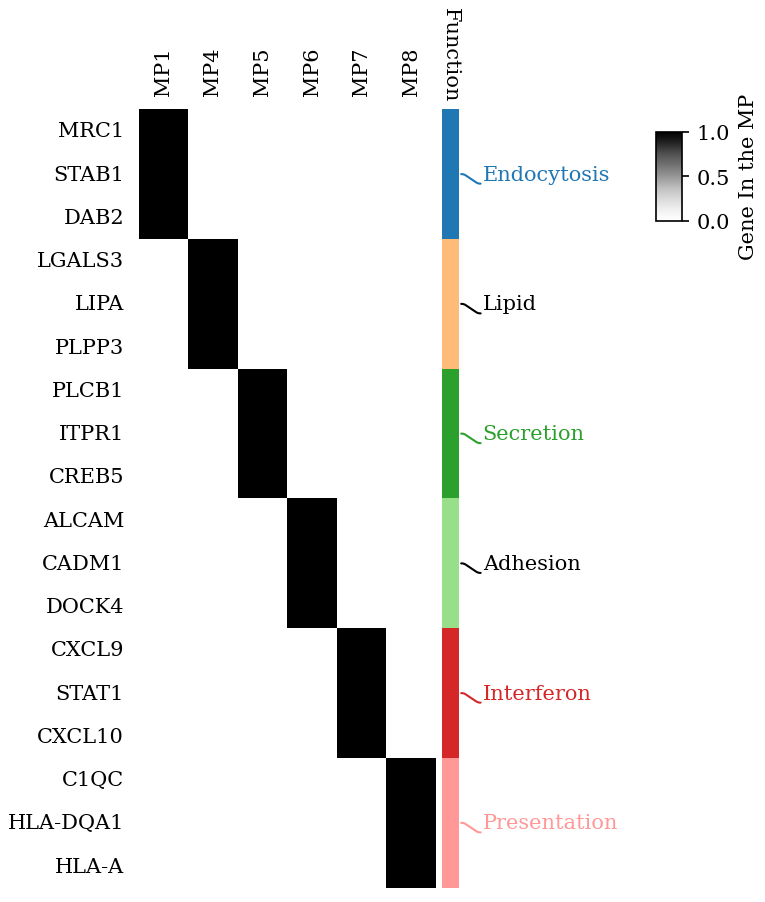

In [30]:
genes = pd.Series(np.vstack(MP_Visual_Genes.values()).flatten())
genes.index=genes
dt = New_MP_Genesets.apply(lambda c: genes.map(lambda x: x in c.values),axis=0).astype(int)
dt = dt.sort_values(dt.columns.tolist())

df_rows = pd.DataFrame(MP_Visual_Genes).unstack().reset_index().set_index(0)
colors = { MP_anno_map[k]:v for k,v in COLOR_PAlETTE['MetaProgram'].items() if k in df_rows['level_0'].unique()}
df_rows['MP'] = df_rows['level_0'].map(MP_anno_map)
df_rows = df_rows.sort_values('level_0')
col_orders = df_rows['level_0'].unique().tolist()
dt = dt[col_orders].sort_values(col_orders,ascending=False)
df_rows = df_rows.loc[dt.index,:]

row_ha = HeatmapAnnotation(
    Function=anno_simple(df_rows['MP'],legend=False,
                           legend_kws=dict(frameon=False),
                           colors=colors),
     Anno=anno_label(df_rows['MP'],legend=False,
                          colors=colors,merge=True),
    verbose=0,axis=0,plot_legend=True)


plt.figure(figsize=(3, 6),dpi=150)
cm = ClusterMapPlotter(data=dt,
                       right_annotation=row_ha,
                       col_cluster=False,
                       row_cluster=False,
                       show_colnames=True,
                       show_rownames=True,
                       vmax=1,
                       vmin=0,
                       label='Gene In the MP',
                       cmap='Greys',rasterized=True,col_names_side='top')
# plt.suptitle('Metaprogram related function')

## Store the annotation

In [31]:
mp_anno_path = f'{RESULT_TABLE}/MPs/{Celltype}/MetaProgram_Annotation.csv'
anno.to_csv(mp_anno_path,index=True)

# Cellstate annotation

In [32]:
scores_path = f'{RESULT_TABLE}/MPs/{Celltype}/signature_scores.csv'
sc.pp.normalize_total(adata, target_sum=1e4)
mp_result = sp.ext.VISION(data=adata,gmt_files=[mp_gmt_path],outdir='.')

mp_result.to_csv(scores_path)
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
ref_anno = pd.read_csv(mp_anno_path)
MP_anno_map = ref_anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
scores.columns = scores.columns.map(lambda x:x.split('_')[0]).map(MP_anno_map)
scores

Rscript /home/analysis/scPipe/scPipe/Rscripts/VISION.R --gmt_files ..//data/table/MPs/Macs/MP_Programs.gmt --h5ad /tmp/tmp2kw5b2nf/count.h5ad --output_file /tmp/tmp2kw5b2nf/vision.tsv
$gmt_files
[1] "..//data/table/MPs/Macs/MP_Programs.gmt"

$h5ad
[1] "/tmp/tmp2kw5b2nf/count.h5ad"

$output_file
[1] "/tmp/tmp2kw5b2nf/vision.tsv"



Loading data from ..//data/table/MPs/Macs/MP_Programs.gmt ...

Using 21898/36601 genes detected in 0.10% of cells for signature analysis.
See the `sig_gene_threshold` input to change this behavior.

Evaluating signature scores on cells...

'as(<matrix>, "dgeMatrix")' is deprecated.
Use 'as(as(as(., "dMatrix"), "generalMatrix"), "unpackedMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Evaluating signature-gene importance...

Warning messages:
1: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.6 GiB
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 3.6 GiB


,Endocytosis,Lipid,Interferon,Adhesion,Secretion,Presentation
AACAAGCCAACAGGAT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,3.992875,0.879809,1.395757,1.853596,2.306032,0.694690
TTATAGCCATATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.292627,0.708676,2.178208,2.016087,4.313478,1.644108
ATCACAATCCCTCTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,5.851803,1.313062,1.196454,0.899567,1.648861,2.029371
CCTCAAACAGGCATGA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.076199,0.871119,0.887830,3.828168,2.517719,2.048970
AGTCAATGTCAATACG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,5.681817,0.897125,0.851532,0.988431,2.056215,0.432011
...,...,...,...,...,...,...
GGATTACTCTCTTATG-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.148689,-0.102083,0.570936,0.309799,1.237055,1.092583
CCTATTAGTCATCCCT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,1.198803,0.526347,0.099910,0.858346,1.318533,1.068628
CTTAGGACATCTCCCA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,1.466722,0.816366,0.309448,2.108650,1.467596,0.567812
GTATCTTGTGAGTATA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,1.974476,1.031726,0.074248,1.007675,0.731349,1.503036


In [33]:
from signaturescoring.scoring_methods.gmm_postprocessing import GMMPostprocessor
import anndata
macs = anndata.AnnData(obs=scores)
# initialize GMMPostprocessor
gmm_post = GMMPostprocessor(
    n_components=scores.shape[1]
)
# fit the GMM model on the 3 columns of the scores
features_name = scores.columns.tolist()
store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(macs,features_name )

# assign clusters to signatures
assignments = gmm_post.assign_clusters_to_signatures(macs,features_name, store_names_proba, plot=False)
scoring_names_gmm = []
for key, val in assignments.items():
    if key =='rest':
        continue
    macs.obs[key+'_gmm'] = macs.obs[val].copy()
    scoring_names_gmm.append(key+'_gmm')

In [34]:
assignments

{'Endocytosis': '4_GMM_proba',
 'Lipid': '0_GMM_proba',
 'Interferon': '5_GMM_proba',
 'Adhesion': '2_GMM_proba',
 'Secretion': '3_GMM_proba',
 'Presentation': '0_GMM_proba',
 'rest': {'1_GMM_proba'}}

In [35]:
curr_val= macs.obs[scoring_names_gmm].idxmax(axis="columns")
cellstate= curr_val.map(lambda x:'Macs.'+x.split('_')[0]).rename('Cellstate').to_frame()
cellstate.to_csv(f'{RESULT_TABLE}/MPs/Macs/Annotation.csv')

In [36]:
# cross sanity check
obs = pd.read_csv(f'{RESULT_TABLE}/GEX_OBS.csv',index_col=0)
adata.obs['Cellstate'] = obs.loc[adata.obs.index,'Cellstate']
pd.crosstab(adata.obs.loc[cellstate.index,'Cellstate'],cellstate['Cellstate'])

Cellstate,Macs.Adhesion,Macs.Endocytosis,Macs.Interferon,Macs.Lipid,Macs.Secretion
Cellstate,,,,,
Macs.Adhesion,1671,0,1,6,199
Macs.Endocytosis,79,2162,72,4,30
Macs.Interferon,96,0,700,334,49
Macs.Lipid,59,0,4,4390,13
Macs.Presentation,721,352,897,550,0
Macs.Secretion,11,5,90,7,873


In [37]:
adata.obs['Cellstate']= cellstate['Cellstate']

## Canonical marker visualization

In [38]:
sp.utils.log1pNorm(adata)
adata.obs = adata.obs.merge(sample_meta,left_on='Sample',right_on='CCG_ID')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 28.22361111111111 mm


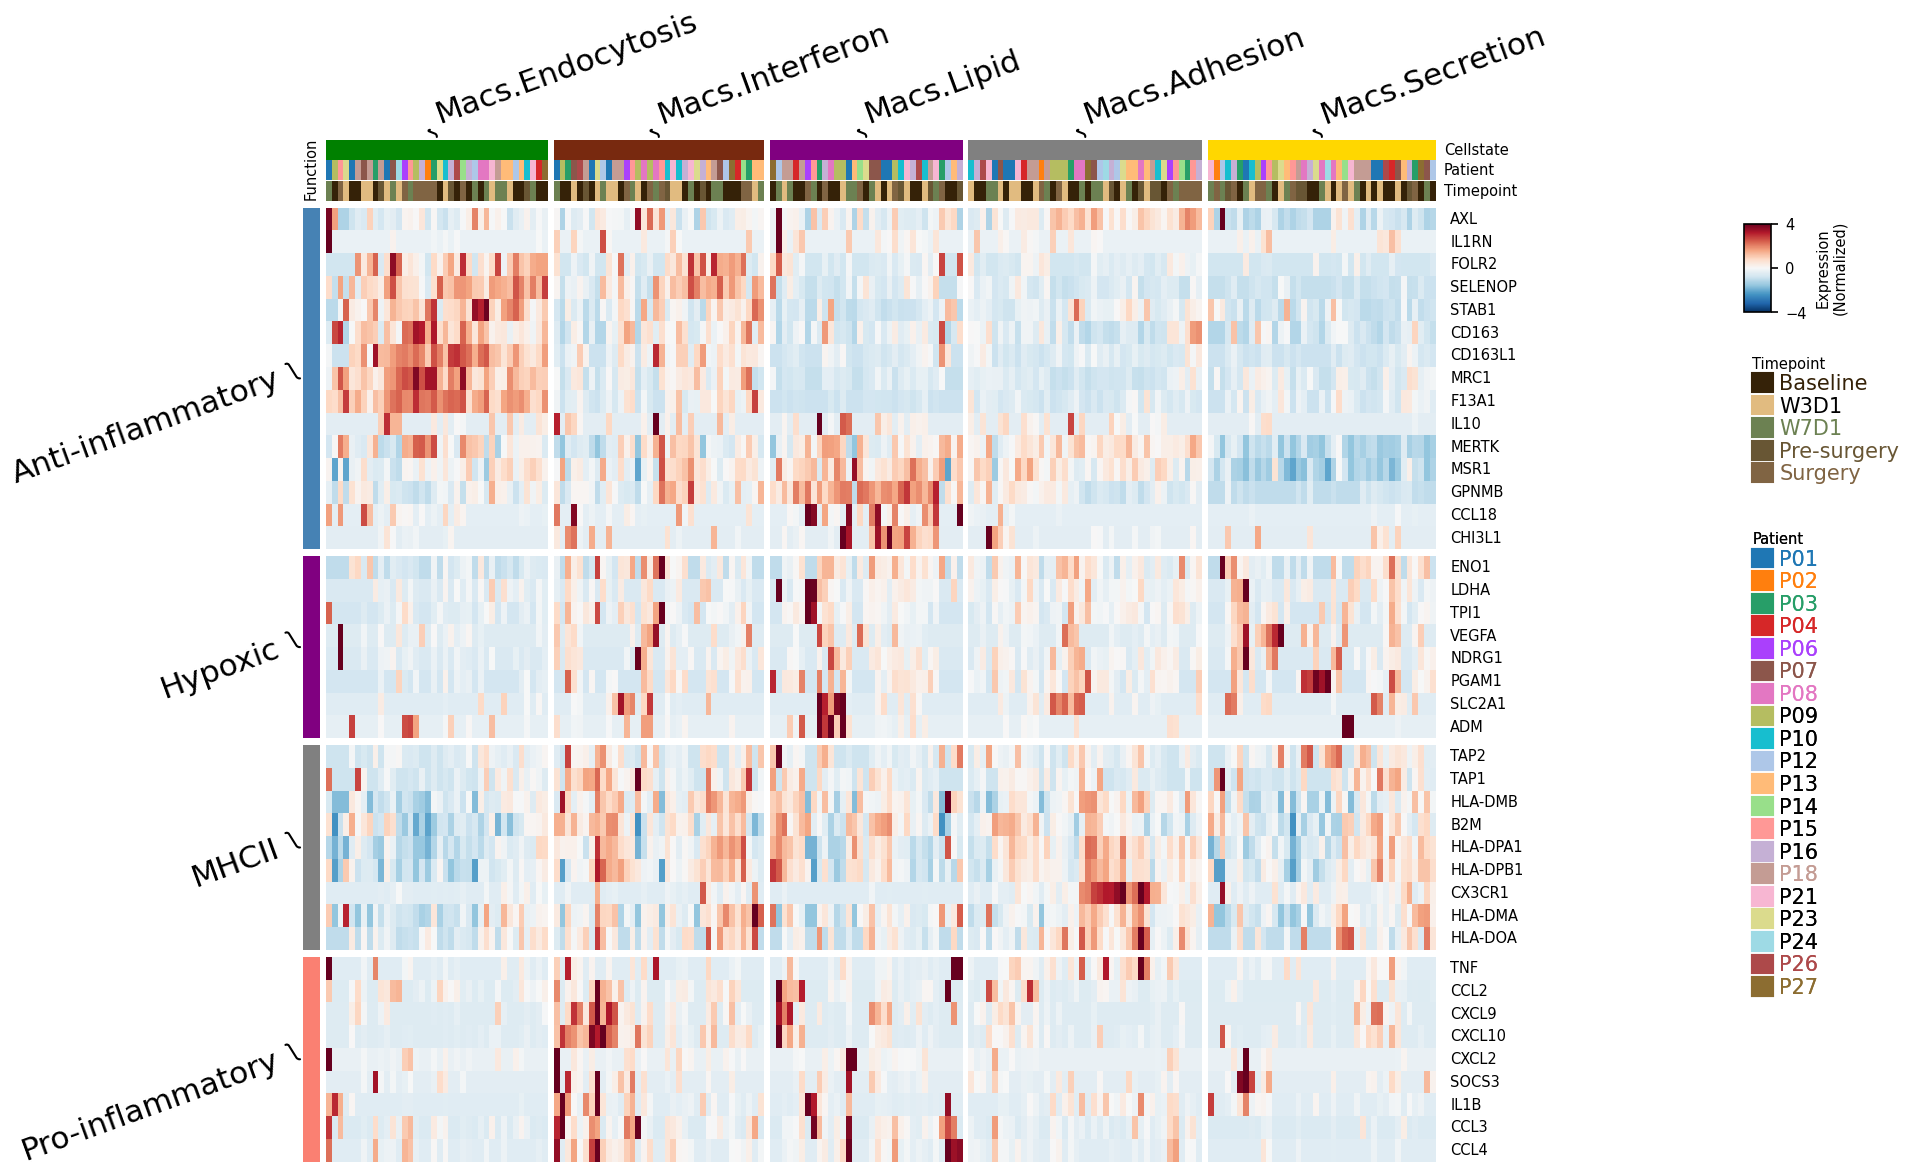

In [39]:
markers = {
    'Anti-inflammatory':['CD163','MRC1','MSR1','CCL18','IL10','FOLR2','STAB1','CD163L1','SELENOP','F13A1','MERTK',
                        'AXL','IL1RN','GPNMB','CHI3L1'],
    'Pro-inflammatory':['IL1B','CCL2','CCL3','CCL4','TNF','CXCL2','CXCL9','CXCL10','SOCS3'],
    'Hypoxic':['VEGFA','SLC2A1','PGAM1','ENO1','LDHA','TPI1','ADM','NDRG1'],
    'MHCII':['B2M','TAP1','TAP2',
             'HLA-DMB', 'HLA-DMA',
             'HLA-DOA', 'HLA-DPA1', 'HLA-DPB1',
            'CX3CR1']
}
marker_df = []
for k,v_list in markers.items():
    for v in v_list:
        marker_df.append(
            pd.Series({v:k},name='Function')
        )
    
marker_df = pd.concat(marker_df).to_frame()
COLOR_PAlETTE['Function']={
    'Anti-inflammatory':'steelblue',
    'Pro-inflammatory':'salmon',
    'Hypoxic':'purple',
    'MHCII':'gray'}
aggregate_heatmap(adata=adata,
                  features=marker_df,
                  top_anno_columns=['Cellstate','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Function',
                  row_split_gap=1,
                  palette=COLOR_PAlETTE,
                  figsize=(10,8),
                  vmin=-4,
                  vmax=4,
                  standard_normalization=True,
                  row_cluster=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )

In [40]:
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
anno = pd.read_csv(mp_anno_path,index_col=0)
MP_anno_map = anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
ref_ITH.columns = ref_ITH.columns.map(MP_anno_map)
ref_ITH=ref_ITH.melt()
ref_ITH.columns = ['Program','gene']
ref_ITH = ref_ITH.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 78.67083333333333 mm


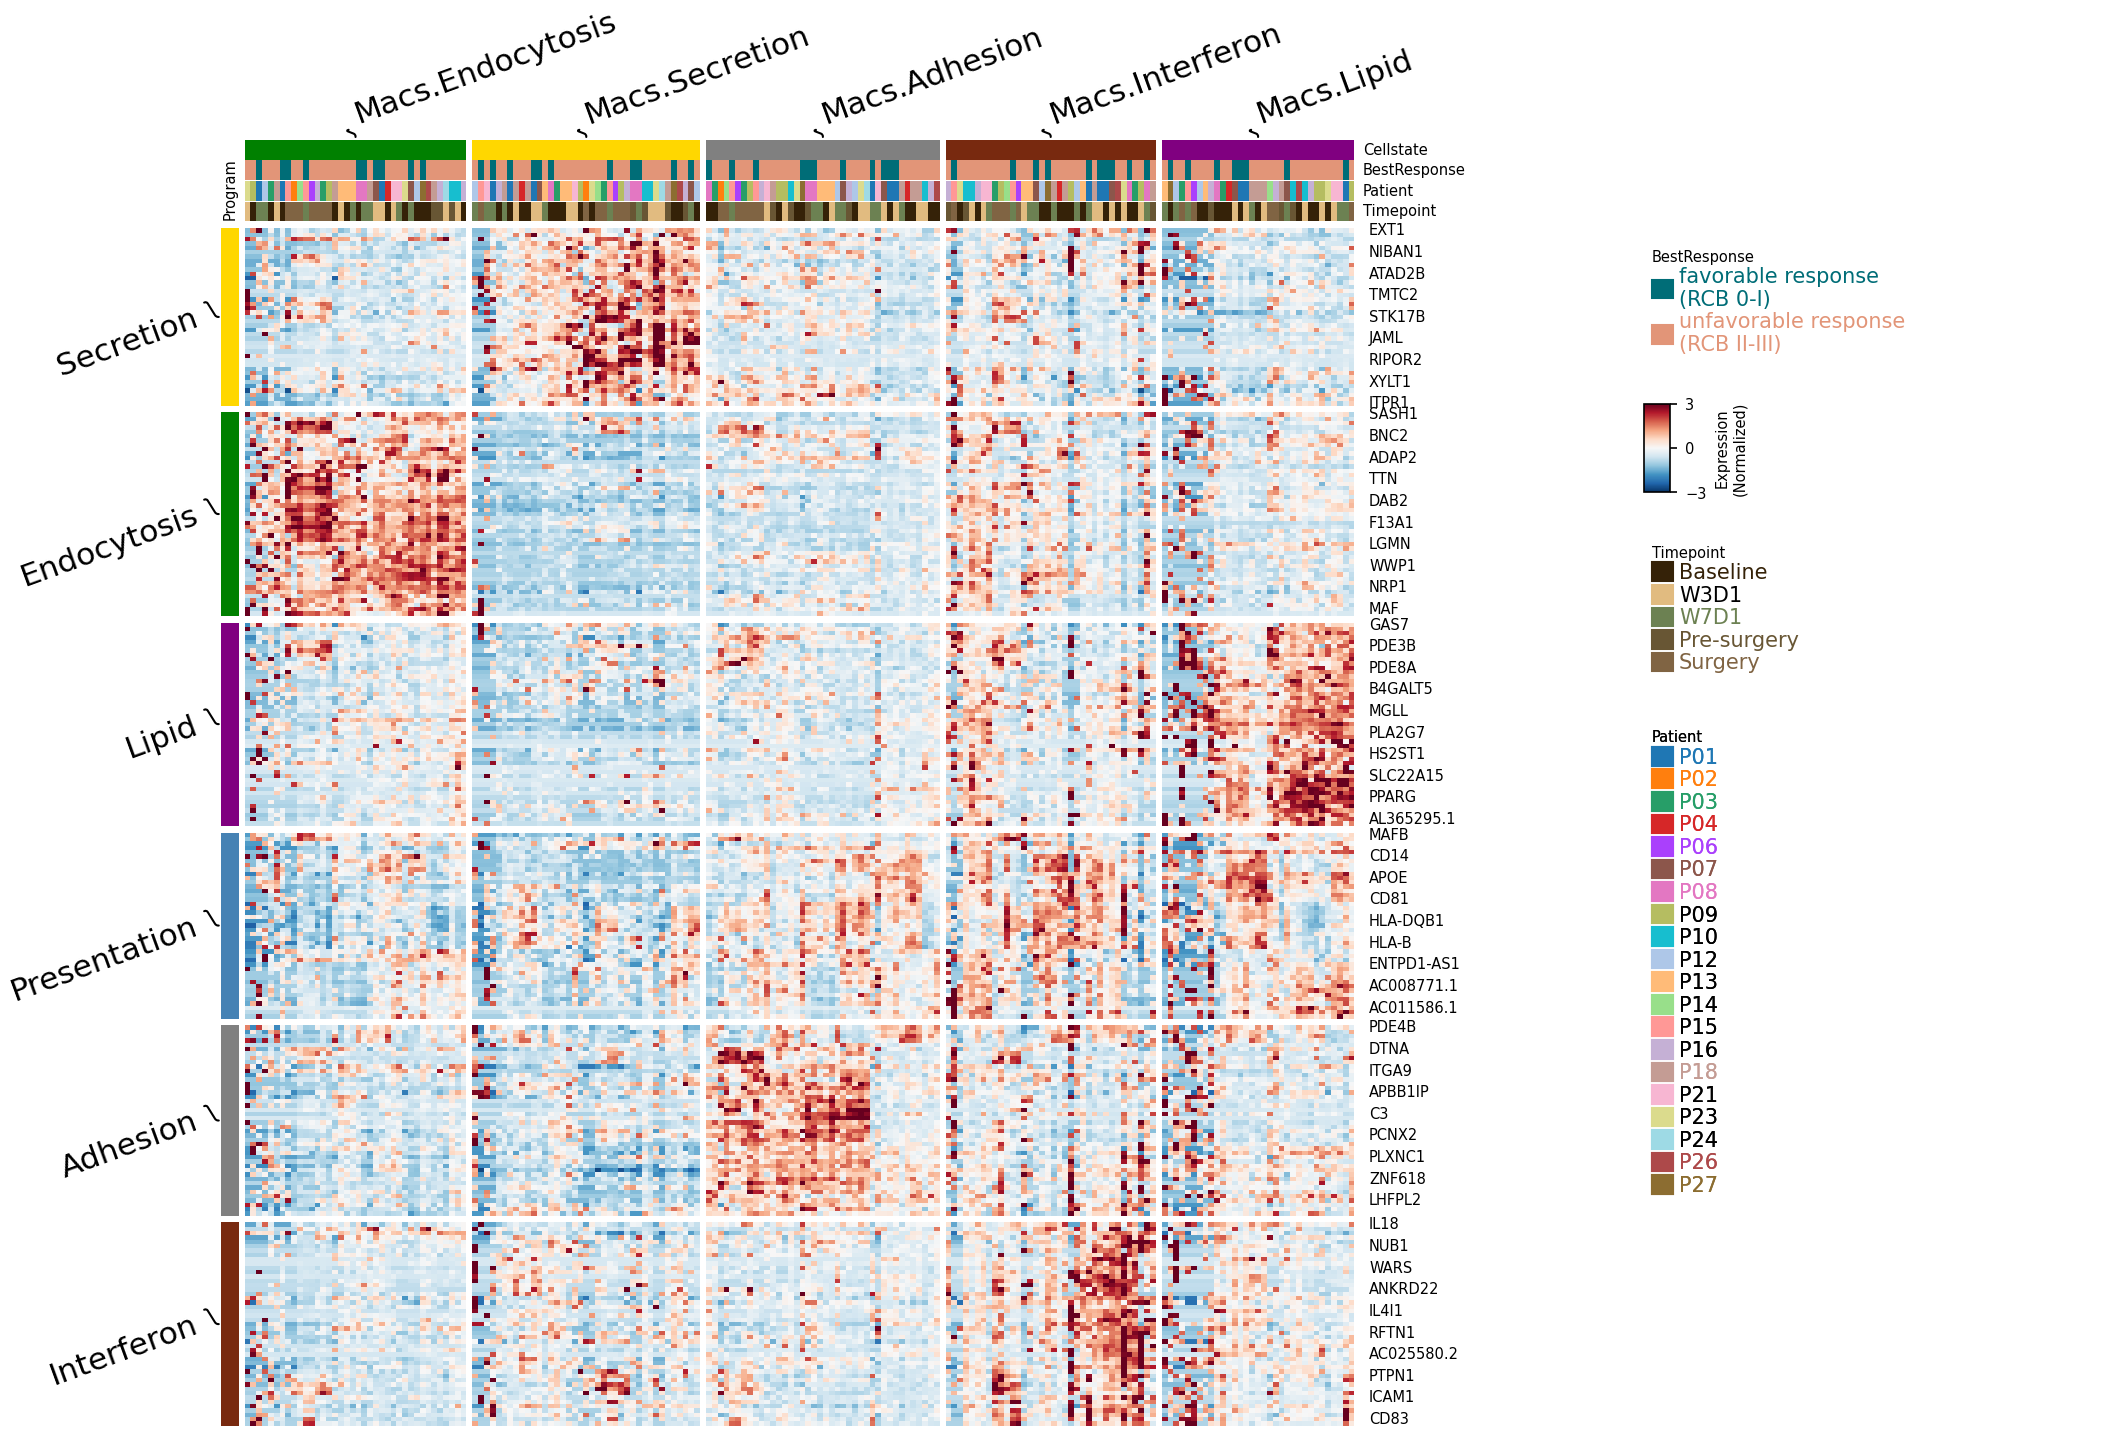

In [41]:
palette={}
palette['Program'] = {k.replace('Macs.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if 'Macs' in k}
for c in ['BestResponse','Patient','Timepoint','Cellstate']:
    palette[c] = COLOR_PAlETTE[c]
aggregate_heatmap(adata=adata,
                  features=ref_ITH,
                  top_anno_columns=['Cellstate','BestResponse','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,10),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )